In [1]:
import json
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18

In [3]:
s = "BAGPOP01_FSR"

In [4]:
with open("../qmof.json") as file:
    qmof_data = json.load(file)
    qmof_df = pd.json_normalize(qmof_data).set_index("qmof_id")


In [3]:
len(qmof_df)

20375

In [5]:
qmof_id = qmof_df[qmof_df["name"] == s].index.item()
qmof_id

'qmof-0cfad40'

In [6]:
bandgap = qmof_df[qmof_df["name"]==s]["outputs.pbe.bandgap"].item()
vbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.vbm"].item()
cbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.cbm"].item()

In [7]:
print(bandgap)
print(vbm)
print(cbm)
print(cbm-vbm)

0.900648
0.080744
0.981392
0.900648


In [8]:
dos_path = os.path.join("../files/EIDyjluDQ3eZnt-gI7Fc4Q/vasp_files/", s, "DOSCAR")

In [21]:
eles = ["Cu"]*2 + ["H"]*16 + ["C"]*28 + ["N"]*16

In [18]:
with open(dos_path) as file:
    lines = file.readlines()
    nions = int(lines[0].split()[1])
    e_info = [float(i) for i in lines[5].split()]
    e_min, e_max, nedos, efermi = e_info[0], e_info[1], int(e_info[2]), e_info[3]

    dos_data = np.array([[float(x) for x in l.split()] for l in lines[6:6+nedos]])

    atom_line_idx = np.array([7+ion_idx+(ion_idx+1)*nedos for ion_idx in range(nions)])
    atom_dos_data = np.array([[[float(x) for x in l.split()] for l in lines[idx:idx+nedos]] for idx in atom_line_idx])

In [19]:
atom_dos_data.shape

(62, 301, 19)

In [24]:
atom_dos_sum = np.sum(atom_dos_data, axis=2)-atom_dos_data[:,:,0]

In [25]:
atom_dos_sum.shape

(62, 301)

In [11]:
efermi

0.20981034

In [12]:
energies = dos_data[:,0]

In [61]:
useful_data = np.array([atom_dos_sum[id, :][(energies>efermi) & (energies<efermi+bandgap)] for id in range(atom_dos_sum.shape[0])])

In [62]:
useful_data.shape

(62, 9)

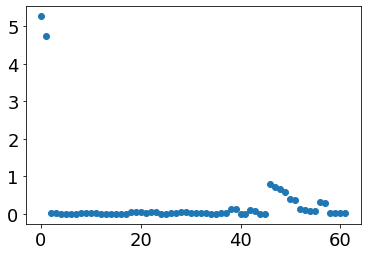

In [65]:
plt.scatter(np.arange(useful_data.shape[0]), np.sum(useful_data, axis=1))

In [210]:
bandgap_data = dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0]<efermi+bandgap)][:-1]
#bandgap_data = bandgap_data[:-1]

In [221]:
sum(bandgap_data[:,1]>0)

0

# read qmofs with peaks in the bandgap

In [8]:
with open("../files/mofs_with_peaks") as f:
    mofs_peak = [l.split() for l in f.readlines()]

In [14]:
len(mofs_peak)

4357

In [13]:
qmof_id_peak = [qmof_df[qmof_df["name"] == q[0]].index.item() for q in mofs_peak]

In [15]:
len(qmof_id_peak)

4357

In [16]:
qmof_id_peak

['qmof-58042a0',
 'qmof-7cf79e0',
 'qmof-29be2c9',
 'qmof-33ca745',
 'qmof-c6eef3b',
 'qmof-905149a',
 'qmof-95de84b',
 'qmof-8d6dc8f',
 'qmof-4a4f095',
 'qmof-a3d97dc',
 'qmof-e13f864',
 'qmof-8a9774d',
 'qmof-d77af39',
 'qmof-072d2d6',
 'qmof-f191a19',
 'qmof-e3afbd2',
 'qmof-ceecaf2',
 'qmof-576f203',
 'qmof-03a39a4',
 'qmof-4629fe7',
 'qmof-f91dbb9',
 'qmof-fb5e34c',
 'qmof-f758424',
 'qmof-e866848',
 'qmof-2323e49',
 'qmof-1bc3291',
 'qmof-cbf7bfe',
 'qmof-a687e6e',
 'qmof-67dc5d7',
 'qmof-7576c28',
 'qmof-5cbf12d',
 'qmof-d128027',
 'qmof-12c6f50',
 'qmof-45d422a',
 'qmof-2e022d9',
 'qmof-248bc84',
 'qmof-bc63522',
 'qmof-53f3394',
 'qmof-8ceaacf',
 'qmof-9a60b76',
 'qmof-ece4651',
 'qmof-f257e1e',
 'qmof-8f1bc5a',
 'qmof-b8e1ccb',
 'qmof-f3ce9b5',
 'qmof-c1a99db',
 'qmof-4f2905b',
 'qmof-796ed67',
 'qmof-fb99880',
 'qmof-9e69850',
 'qmof-13989ad',
 'qmof-e4d40d7',
 'qmof-af52ec1',
 'qmof-a87149e',
 'qmof-1d1d359',
 'qmof-9047456',
 'qmof-16abc05',
 'qmof-54c3ea8',
 'qmof-4bfccae

In [17]:
import shutil

In [20]:
for x in qmof_id_peak:
    src = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots", x+".png")
    dst = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots_peaks", x+".png")
    shutil.copyfile(src, dst)